# Спортивные сообщества VK

## _"Определить вид спорта по посту" (Задача классификации)_


Данные: https://www.kaggle.com/datasets/mikhailma/russian-social-media-text-classification

## Часть 0. Введение

### Обзор

Данный датасет, как мы увидим здесь состоит из 3 колонок и 38740 строк.

**Метаданные**

* **oid** - id сообщества
* **category** - вид спорта (таргет)
* **text** - текст поста

### Контекст:
На основе заданного набора постов определите, какой вид спорта обсуждается в выбранном сообществе.

**Список категорий**

    1.athletics,
    2.autosport,
    3.basketball,
    4.boardgames,
    5.esport,
    6.extreme,
    7.football,
    8.hockey,
    9.martial arts,
    10.motosport,
    11.tennis,
    12.volleyball,
    13.winter_sport
    
### Оценочная метрика:

In [52]:
def score(true, pred, n_samples):
    counter = 0
    if true == pred:
        counter += 1
    else:
        counter -= 1
    return counter / n_samples

## Часть 1: Импорт, загрузка данных

### Загрузка библиотек

In [85]:
import pandas as pd
import numpy as np

import re
from collections import Counter

from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier


### Загрузка данных в датафрейм vk_sport

In [54]:
vk_sport = pd.read_csv('train.csv', encoding_errors = 'ignore')

## Часть 2. Анализ данных (EDA)

In [55]:
vk_sport.head()

,oid,category,text
0,365271984,winter_sport,Волшебные фото Виктория Поплавская ЕвгенияМедв...
1,503385563,extreme,Возвращение в подземелье Треша 33 Эйфория тупо...
2,146016084,football,Лучшие чешские вратари – Доминик Доминатор Гаш...
3,933865449,boardgames,Rtokenoid Warhammer40k валрак решил нас подкор...
4,713550145,hockey,Шестеркин затаскивает Рейнджерс в финал Восточ...


In [56]:
vk_sport.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38740 entries, 0 to 38739
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   oid       38740 non-null  int64 
 1   category  38740 non-null  object
 2   text      38740 non-null  object
dtypes: int64(1), object(2)
memory usage: 908.1+ KB


В таблице 3 колонки и 38740 строк.  
2 типа данных int64(1 колонка) и object(2 колонки)  
Пропущенных значений нет

In [57]:
vk_sport.describe(include=[object])

,category,text
count,38740,38740
unique,13,35774
top,autosport,За кроссовками в Баскетбольный магазин Ghetto ...
freq,3160,163


В колонке category - 13 уникальных значений.  
В колонке text - есть дублирующие тексты

In [58]:
# количество уникальных сообществ
vk_sport.oid.nunique()

3874

In [59]:
# есть ли сообщества с несколькими категориями?
vk_sport.groupby('oid').category.nunique().to_frame().query('category>1')

,category
oid,


Все сообщества в данном датасете имеют по одной категории

In [60]:
print('Количество классов:', vk_sport.category.nunique())
print('Распределение количества строк по категориям:')
vk_sport.category.value_counts()

Количество классов: 13
Распределение количества строк по категориям:


autosport       3160
extreme         3110
martial_arts    3050
motosport       3030
boardgames      3020
tennis          3000
esport          2990
athletics       2970
hockey          2950
volleyball      2950
football        2860
basketball      2850
winter_sport    2800
Name: category, dtype: int64

<AxesSubplot:>

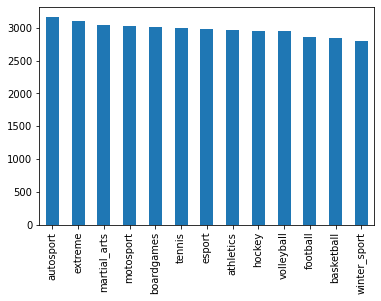

In [61]:
# визуализация распределения таргета "category"
vk_sport['category'].value_counts().plot(x = vk_sport['category'], kind='bar')

In [106]:
vk_sport['oid'].value_counts().unique()

array([10])

Имеем сбалансированный датасет

### Анализ колонки 'text'

In [78]:
# посмотрим на пример текста
vk_sport.at [406,'text']

'Коллеги традиционно объявляем очередной гильдейский настольныйсубботник ГРаНИ 33 По аналогии с индустрией компьютерных игр это предложение по субботам в течение дня выкладывать в комментарии к посту фото своих разработок с кратким описанием. А в ответ на выложенное другими интересоваться советовать предлагать сотрудничество и просто ставить лайки. Рассказывайте над чем сейчас работаете?'

В тексте есть слова содержащие 'tokenoid' - скорее всего являются заменой ссылок.
Есть слова на латинице.
А также цифры и пунктуация.  
Все слова написаны с применением разных регистров.


In [64]:
print(f"В колонке текст имеются дублирующие посты в количестве = {vk_sport['text'].shape[0] - vk_sport['text'].nunique()} строк")

В колонке текст имеются дублирующие посты в количестве = 2966 строк


## Часть 3. Обработка и преобразование данных

### Приведем тексты постов к общему виду:
 - переводим символы в нижний регистр
 - удалим все слова цифры, пунктуацию и слова содержащие подстроку 'tokenoid'(видимо зашифрованы ссылки)

In [79]:
def prepose_text(text):
    text = text.lower()
    # убираем цифры 
    clean_text = re.sub("[0-9]", "", text)
    # убираем ссылки
    clean_text = re.sub(r"([a-z]+)?tokenoid([a-z]+)?", "", text)
    # оставляем только буквенные символы
    clean_text = re.sub("[^а-яa-z]"," ", clean_text)
    # убираем лишние пробелы
    clean_text = re.sub(" +", " ", clean_text)
    return clean_text

In [80]:
# создаем колонку с преобразованным текстом
vk_sport['clean_text'] = vk_sport['text'].map(prepose_text)

In [81]:
print(f"В колонке 'clean_text' количество дублирующих постов = {vk_sport['text'].shape[0] - vk_sport['clean_text'].nunique()} строк")

В колонке 'clean_text' количество дублирующих постов = 3154 строк


### Разделение данных на train, valid и test

In [ ]:
train, valid = train_test_split(vk_sport[['oid','clean_text','category']], test_size=0.1, random_state=42)
train, test = train_test_split(train, test_size=0.2, random_state=42)

In [84]:
# размеры полученных датасетов
len_train = train.shape[0]
len_valid = valid.shape[0]
len_test = test.shape[0]

print(f'Размер датасетов train={len_train}, valid={len_valid}, test={len_test}')

Размер датасетов train=24793, valid=7748, test=6199


### Удаление дубликатов

In [102]:
train_no_duplicated = train.drop_duplicates(subset=['clean_text'])
valid_no_duplicated = valid.drop_duplicates(subset=['clean_text'])
test_no_duplicated = test.drop_duplicates(subset=['clean_text'])

In [103]:
len_train_no_duplicated = train_no_duplicated.shape[0]
len_valid_no_duplicated = valid_no_duplicated.shape[0]
len_test_no_duplicated = test_no_duplicated.shape[0]

print(f'Размер датасетов train={len_train_no_duplicated}, valid={len_valid_no_duplicated}, test={len_test_no_duplicated}')

Размер датасетов train=23350, valid=7506, test=6047


In [110]:
test_no_duplicated['category'].value_counts().unique()

array([515, 513, 503, 502, 471, 470, 459, 458, 451, 440, 434, 426, 405])

In [112]:
train_no_duplicated

,oid,category,text,clean_text,occurrence
12415,943594482,basketball,Тут это. . Лейкерс играли против Наггетс но иг...,тут это лейкерс играли против наггетс но иг...,1
31186,807866759,winter_sport,Мартен делится секретами биатлонной стрельбы н...,мартен делится секретами биатлонной стрельбы н...,1
35973,569789680,athletics,МЫ ПРИГЛАШАЕМ ВАС В КОМПАНИЮ ЕДИНОМЫШЛЕННИКОВ ...,мы приглашаем вас в компанию единомышленников ...,1
32619,241706654,autosport,Ничего так не учит слесарному делу как русские...,ничего так не учит слесарному делу как русские...,1
15795,194568678,winter_sport,Четырехкратный олимпийский чемпион по биатлону...,четырехкратный олимпийский чемпион по биатлону...,1
...,...,...,...,...,...
36062,77264253,athletics,Интенсивное зажигательное ОФП Силовые трениров...,интенсивное зажигательное офп силовые трениров...,1
2703,101460995,martial_arts,А вы знали что у олимпийского чемпиона по воль...,а вы знали что у олимпийского чемпиона по воль...,1
762,408171989,boardgames,Предзаказ игры Войны Черной розы продолжается ...,предзаказ игры войны черной розы продолжается ...,1
5541,118939182,volleyball,Ирина Воронкова В финале статистика не имеет з...,ирина воронкова в финале статистика не имеет з...,1


## Часть 4: Машинное обучение

In [113]:
X_train = train_no_duplicated[['oid','clean_text']]
y_train = train_no_duplicated['category']

X_valid = valid_no_duplicated[['oid','clean_text']]
y_valid = valid_no_duplicated['category']

X_test = test_no_duplicated[['oid','clean_text']]
y_test = test_no_duplicated['category']
